In [76]:
#
import mne
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy.signal import butter, lfilter,resample,coherence
from scipy import io
from scipy import stats
import librosa
from scipy.signal import hilbert
from IPython.display import clear_output

sns.set(style="darkgrid")
sns.set(font_scale=1.5)
import matplotlib as mpl

data_path = os.path.dirname(os.getcwd())

subject_name = ['stella','juliet','shai','ayoub','lucas','simone','henry', 'julien','marion','elvira']
subject_group = [('stella','juliet'),('shai','ayoub'),('lucas','simone'),('henry', 'julien'),('marion','elvira')]
#subject_group = [1,1,2,2,3,3,4,4,5,5]
subject_gender = ['f','f','m','m','m','m','m','m','f','f']
subject_speak = [1, 2, 1, 2, 1, 2, 1, 2, 1, 2]
session_name = ['pre','duet1', 'duet2', 'duet3' ,'duet4','duet5','duet6','post']
session_words = [60,50,50,50,50,50,50,60]
eeg_label =     ['F3','C3','P3','Cz','F4','C4','P4','P7']
ema_label = ['jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

ema_fs = 100

idx = [np.arange(1,60),np.arange(61,160),np.arange(161,260),np.arange(261,360),np.arange(361,460)
       ,np.arange(461,560),np.arange(561,660),np.arange(661,720)]

raw_fname = data_path + '/fieldtrip/data/enobio8_ferrara_french2.mat'
mat = io.loadmat(raw_fname)
pos = mat['lay']['pos'][0][0]



In [81]:
method = 'coh'
mode = 'fourier'

In [82]:
# load coherence with speech envelope data during listening

save_path = data_path + '/python/data/entrement_coh.pkl'
save_path = data_path + '/python/data/entrement_'+method+'_'+mode+'.pkl'

df=pd.read_pickle(save_path)

a  = df['Data'].apply(lambda x: np.mean(x))
df['Coherence'] = pd.Series(a, index=df.index)
A = df.reset_index()
a = pd.DataFrame(np.column_stack(list(zip(*A.Data))), columns=eeg_label)
df = pd.concat([A,a], axis=1)



B=df.drop(['Data','index'], axis=1)
B=B.reset_index()

entrainment = B.melt(['index','name','group','subject','session_name','session',
            'freq','Coherence'], var_name='channel', value_name='data')
entrainment = entrainment.drop(['index'], axis=1)

entrainment.head()

,name,group,subject,session_name,session,freq,Coherence,channel,data
0,stella_juliet,0,both,all,0,0.9,0.047220,F3,0.046613
1,stella_juliet,0,both,all,0,1.7,0.028845,F3,0.037992
2,stella_juliet,0,both,all,0,2.6,0.021173,F3,0.007033
3,stella_juliet,0,both,all,0,3.5,0.022322,F3,0.031228
4,stella_juliet,0,both,all,0,4.3,0.039424,F3,0.050394


In [131]:
n_components = [4,8,16,32,64,128,256,512]
covariance_type='diag'

freq=[(1,4),(4,8),(8,12),(13,18),(18,30)]
freq = np.vstack((np.arange(1,40,1),np.arange(3,42,1))).T


In [132]:
#
A=[]
for s in subject_name:
    for f in range(0,len(freq)):
        a = entrainment[(entrainment['session'] == 0)&(entrainment['subject'] ==s)
          &(entrainment['freq'].between(freq[f][0], freq[f][1], inclusive=False))]

        b = a['Coherence'].get_values().mean()
        a = pd.DataFrame({'subject':[s],'Freq':str(freq[f][0])+' - '+str(freq[f][1]),
                          'Coherence':b})
        A.append(a)
        
A=pd.concat((A),axis=0)
A.head()



,subject,Freq,Coherence
0,stella,1 - 3,0.033806
0,stella,2 - 4,0.032994
0,stella,3 - 5,0.033520
0,stella,4 - 6,0.031305
0,stella,5 - 7,0.039472


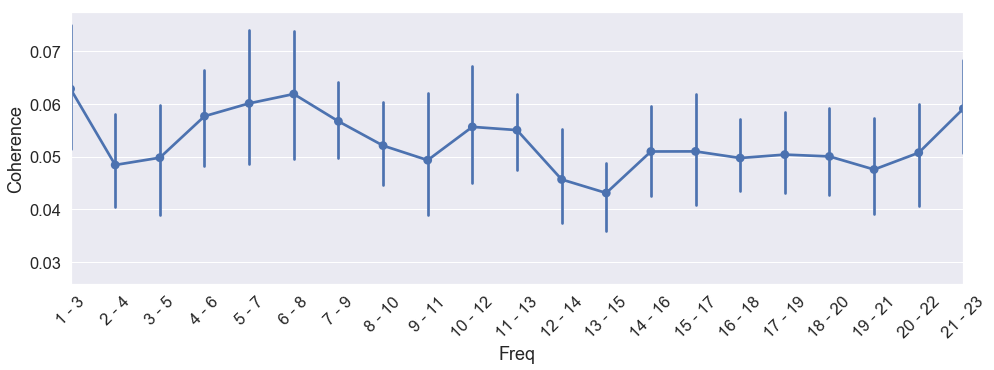

In [133]:
f, ax = plt.subplots(figsize=(16,5))

_=sns.pointplot(data=A,x='Freq',y='Coherence')
_=plt.xlim([0,20])
_=plt.xticks(rotation=45)

In [93]:
# convergence_entrainment in frequency bands
convergence_entrainment = []

for i in range(0,len(n_components)):    
    save_path = data_path + '/python/data/conv_'+covariance_type+'_'+str(n_components[i])+'.pkl'
    convergence=pd.read_pickle(save_path)
    
    for s in subject_name:
        for f in range(0,len(freq)):
            a = entrainment[(entrainment['session'] == 0)&(entrainment['subject'] == s)
              &(entrainment['freq'].between(freq[f][0], freq[f][1], inclusive=False))]
            a=a['Coherence'].get_values()
            a=np.mean(a)

            b = convergence[(convergence['subject'] == s)&
                            (convergence['type'] == 'Convergence')]['mean_score_ratio']
            b=np.mean(b)

            a = pd.DataFrame({'subject':[s],'Freq':str(freq[f][0])+' - '+str(freq[f][1]),
                             'Coherence':a,'Convergence_Frequency':b,'GMM_comp':n_components[i]})
            convergence_entrainment.append(a)
        
convergence_entrainment=pd.concat((convergence_entrainment),axis=0)
convergence_entrainment.head()    
    

,subject,Freq,Coherence,Convergence_Frequency,GMM_comp
0,stella,1 - 3,0.033806,1.209437,4
0,stella,2 - 4,0.032994,1.209437,4
0,stella,3 - 5,0.033520,1.209437,4
0,stella,4 - 6,0.031305,1.209437,4
0,stella,5 - 7,0.039472,1.209437,4


In [94]:
# correaltion between coherence and convergence frequency

corr=[]
for i in range(0,len(n_components)):
    for f in range(0,len(freq)):
        a = convergence_entrainment[(convergence_entrainment['GMM_comp'] == n_components[i])
                                    &(convergence_entrainment['Freq']==
                                      str(freq[f][0])+' - '+str(freq[f][1]))]
        r,p = stats.pearsonr(a['Coherence'],a['Convergence_Frequency'])
        a = pd.DataFrame({'Freq_name':[str(freq[f][0])+' - '+str(freq[f][1])],
                          'freq':(freq[f][1]+freq[f][0])/2,
                          'p':p,'r':r,'GMM_comp':n_components[i]})
        corr.append(a)
corr=pd.concat((corr),axis=0)
corr = corr.dropna()

corr.head()            

,Freq_name,freq,p,r,GMM_comp
0,1 - 3,2.0,0.623442,0.177641,4
0,2 - 4,3.0,0.081312,0.576127,4
0,3 - 5,4.0,0.863941,0.062441,4
0,4 - 6,5.0,0.488808,-0.248467,4
0,5 - 7,6.0,0.870678,-0.059327,4


Text(0.5, 1.0, 'Convergence_Frequency vs  Coherence')

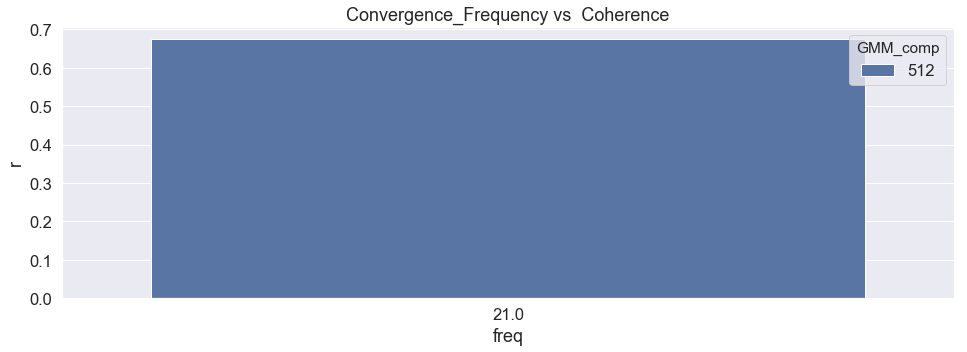

In [95]:
#
a=corr[corr['p'] <0.05]

f, ax = plt.subplots(figsize=(16,5))

_=sns.barplot(data=a,x='freq',y='r',hue='GMM_comp')
plt.title('Convergence_Frequency vs  Coherence')

In [96]:

_=sns.lmplot(x="Convergence_Frequency", y='Coherence',hue="GMM_comp",
             col="GMM_comp",data=A,col_wrap=4)

plt.suptitle('Freq '+str(freq[0])+' - '+str(freq[1]))

KeyError: "['Convergence_Frequency' 'GMM_comp'] not in index"

# trial wise data analysis

In [123]:
# trial wise plv
save_path = data_path + '/python/data/entrement_plv_trialwise.pkl'

df=pd.read_pickle(save_path)
entrainment_trialwise = df.melt(['subject','session','wordNo','freq'], 
                                var_name='channel', value_name='value')
entrainment_trialwise['IDX'] =  entrainment_trialwise['subject']+'_'+entrainment_trialwise['session'].astype(str)+'_'+entrainment_trialwise['wordNo'].astype(str)


entrainment_trialwise = entrainment_trialwise[entrainment_trialwise['freq']<=10]
entrainment_trialwise.head()


,subject,session,wordNo,freq,channel,value,IDX
0,juliet,1,1,1.5,F3,0.693621,juliet_1_1
1,stella,1,1,1.5,F3,0.290740,stella_1_1
2,juliet,1,2,1.5,F3,0.582450,juliet_1_2
3,stella,1,2,1.5,F3,0.965972,stella_1_2
4,juliet,1,3,1.5,F3,0.782900,juliet_1_3


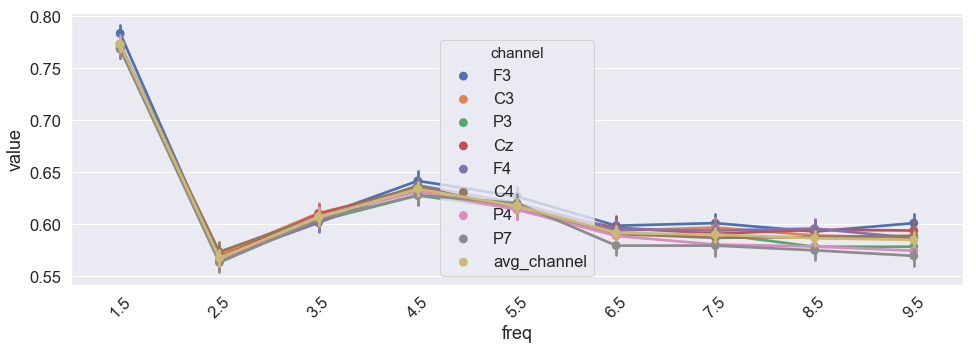

In [124]:
# plot plv vs freq
f, ax = plt.subplots(figsize=(16,5))

_=sns.pointplot(data=entrainment_trialwise,x='freq',y='value',hue='channel')
#_=plt.xlim([0,20])
_=plt.xticks(rotation=45)

In [125]:
# correaltion between coherence and convergence frequency
freq = np.unique(convergence_entrainment_trialwise['freq'])
eeg_label =     ['F3','C3','P3','Cz','F4','C4','P4','P7','avg_channel']

corr=[]
for i in range(0,len(n_components)):
    save_path = data_path + '/python/data/conv_'+covariance_type+'_'+str(n_components[i])+'.pkl'
    convergence=pd.read_pickle(save_path)
    convergence['IDX'] =  convergence['subject']+'_'+convergence['session'].astype(str)+'_'+convergence['wordNo'].astype(str)
    convergence_entrainment_trialwise = convergence.merge(entrainment_trialwise, on=['IDX'])
    
    for f in range(0,len(freq)):
        for ch in range(0,len(eeg_label)):
            a = convergence_entrainment_trialwise[(convergence_entrainment_trialwise['GMM_comp'] 
                                                   == n_components[i])
                                        &(convergence_entrainment_trialwise['freq']==freq[f])
                                        & (convergence_entrainment_trialwise['type']=='Convergence')
                                        &(convergence_entrainment_trialwise['channel']==eeg_label[ch])]

            r,p = stats.pearsonr(a['mean_score_ratio'],a['value'])
            a = pd.DataFrame({'freq':[freq[f]],'p':p,'r':r,'GMM_comp':n_components[i]
                             ,'channel':eeg_label[ch]})
            corr.append(a)
corr=pd.concat((corr),axis=0)
corr = corr.dropna()

corr.head()      

,freq,p,r,GMM_comp,channel
0,1.5,0.400248,0.038561,4,F3
0,1.5,0.390557,0.039360,4,C3
0,1.5,0.207554,0.057749,4,P3
0,1.5,0.094185,0.076642,4,Cz
0,1.5,0.035307,0.096301,4,F4


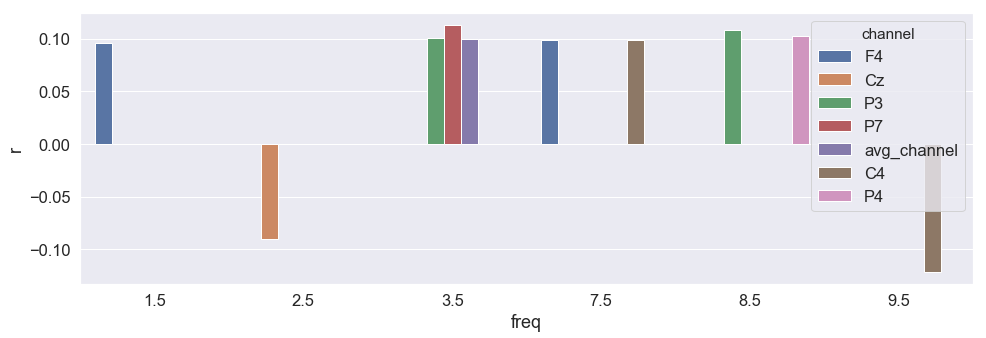

In [134]:
a=corr[(corr['p'] <0.05)&(corr['GMM_comp']==4)]
f, ax = plt.subplots(figsize=(16,5))

_=sns.barplot(data=a,x='freq',y='r',hue='channel')

Text(0.5, 1.0, 'Convergence effort vs  Coherence')

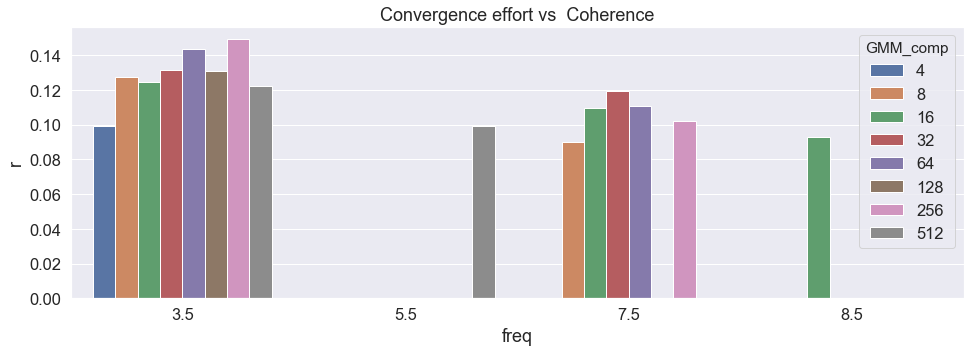

In [130]:
#
a=corr[(corr['p'] <0.05)&(corr['channel']=='avg_channel')]

f, ax = plt.subplots(figsize=(16,5))

_=sns.barplot(data=a,x='freq',y='r',hue='GMM_comp')
plt.title('Convergence effort vs  Coherence')

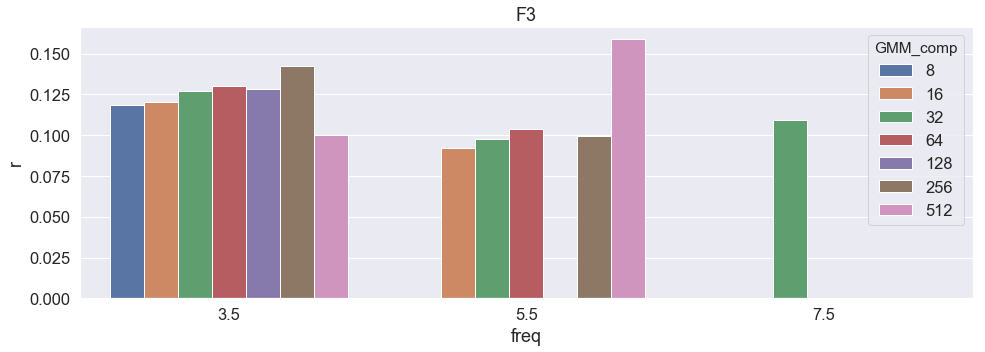

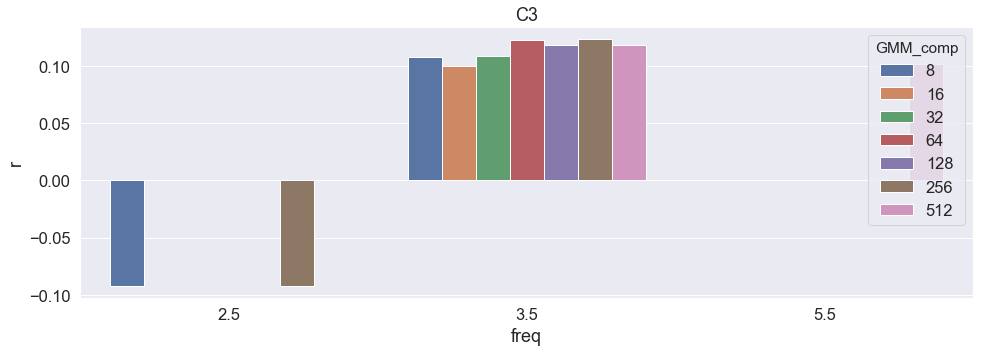

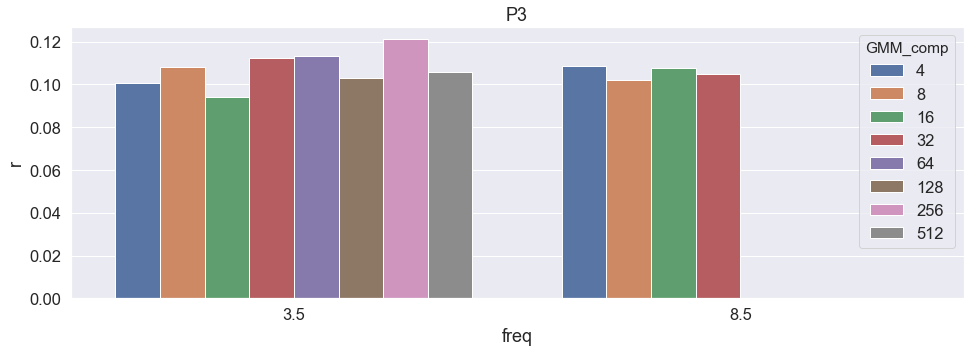

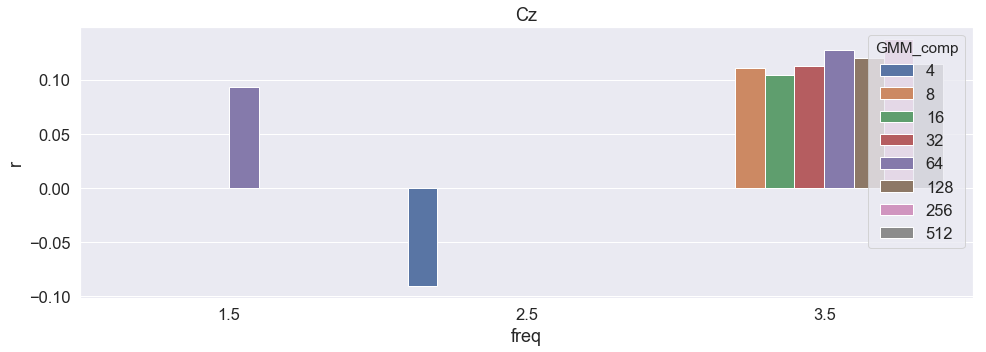

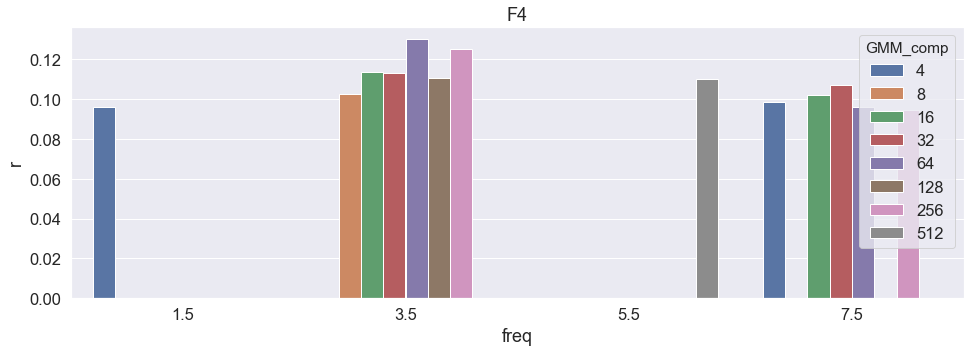

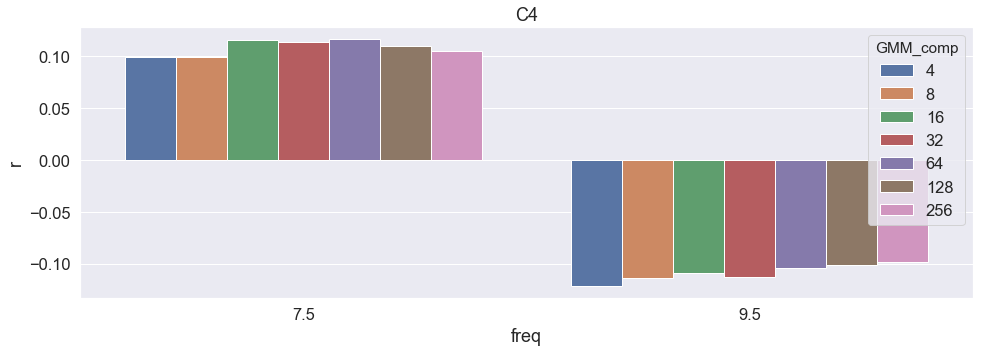

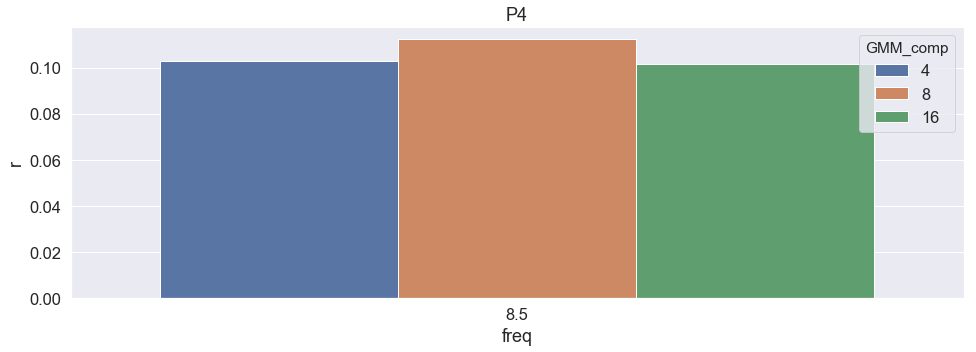

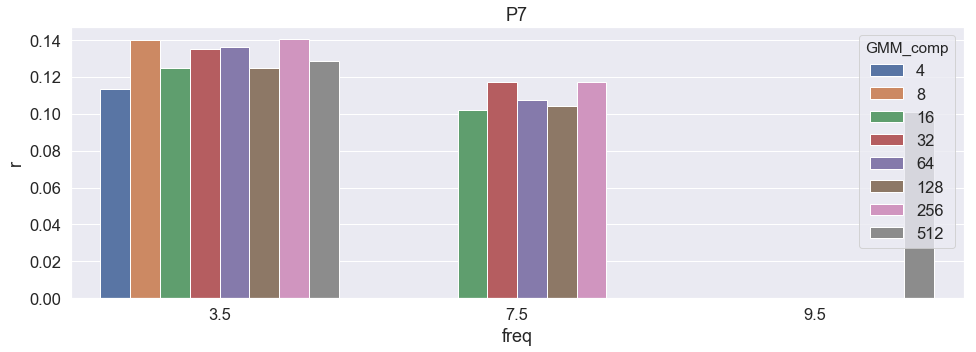

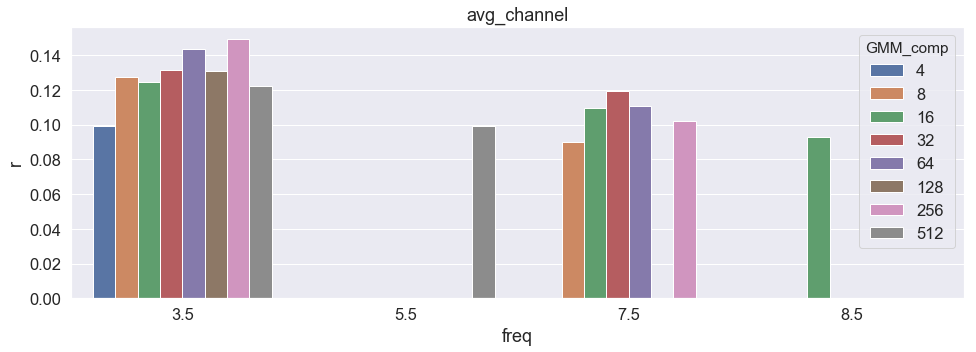

In [108]:
#
for ch in range(0,len(eeg_label)):
    a=corr[(corr['p'] <0.05)&(corr['channel']==eeg_label[ch])]

    f, ax = plt.subplots(figsize=(16,5))

    _=sns.barplot(data=a,x='freq',y='r',hue='GMM_comp')
    plt.title(eeg_label[ch])

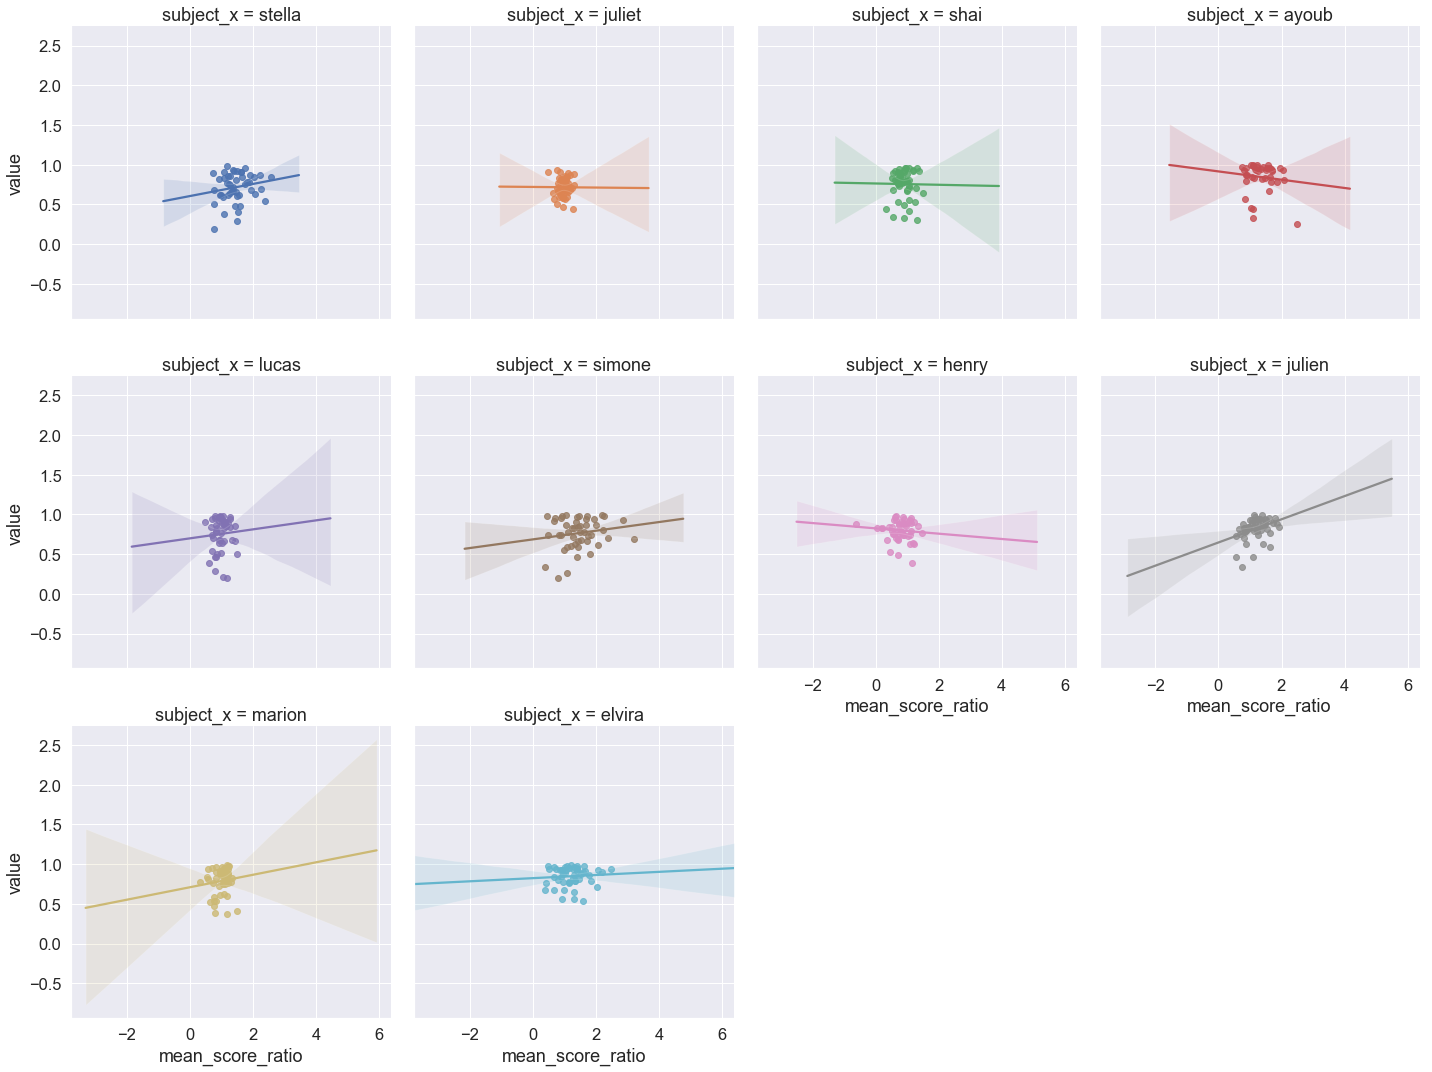

In [43]:
#
A = convergence_entrainment_trialwise[(convergence_entrainment_trialwise['channel']=='avg_channel')
                                     & (convergence_entrainment_trialwise['GMM_comp']==4)
                                     & (convergence_entrainment_trialwise['type']=='Convergence')
                                     & (convergence_entrainment_trialwise['freq']==1.5)]


_=sns.lmplot(x="mean_score_ratio", y='value',hue="subject_x",
             col="subject_x",data=A,col_wrap=4)